<a href="https://colab.research.google.com/github/N-amrata/Data-Science/blob/master/Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [765]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

In [766]:
train=pd.read_csv('train.csv')



In [767]:
train.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,csid_1,13.168425,9.447662,-0.070203,-0.139541,0.436956,4.705761,2.537985,7.959503,C,F,0
1,csid_2,17.092979,7.329056,0.153298,-0.102726,0.380340,4.205138,4.193444,17.517381,C,A,0
2,csid_3,17.505334,5.143676,0.106709,0.262834,0.417648,4.479070,3.878971,12.595155,C,BA,0
3,csid_4,31.423381,4.917740,-0.020226,-0.100526,0.778130,5.055535,2.708940,4.795073,AA,F,0
4,csid_5,11.909502,4.237073,0.187178,0.172891,0.162067,3.445247,3.677360,56.636326,C,AA,0


In [768]:
train['X1'].value_counts()

BA    4511
A     2268
F     2235
AA    1611
E       76
Name: X1, dtype: int64

In [769]:
train['customer_active_segment'].value_counts()

C     4919
B     4430
D      536
AA     418
A      412
Name: customer_active_segment, dtype: int64

In [770]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10738 entries, 0 to 10737
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       10738 non-null  object 
 1   customer_visit_score              10738 non-null  float64
 2   customer_product_search_score     10696 non-null  float64
 3   customer_ctr_score                10738 non-null  float64
 4   customer_stay_score               10701 non-null  float64
 5   customer_frequency_score          10738 non-null  float64
 6   customer_product_variation_score  10692 non-null  float64
 7   customer_order_score              10672 non-null  float64
 8   customer_affinity_score           10738 non-null  float64
 9   customer_active_segment           10715 non-null  object 
 10  X1                                10701 non-null  object 
 11  customer_category                 10738 non-null  int64  
dtypes: f

In [771]:
train.describe()

,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_category
count,10738.000000,10696.000000,10738.000000,10701.000000,10738.000000,10692.000000,10672.000000,10738.000000,10738.000000
mean,19.060941,5.274847,0.175912,0.374230,2.376895,5.788180,3.150071,17.061836,0.120600
std,7.419609,1.882559,0.372829,1.222031,5.601911,2.531309,1.035416,18.762693,0.325677
min,0.568965,-0.161940,-0.547989,-0.462494,0.028575,2.752836,0.363338,-0.486834,0.000000
25%,13.518021,3.971587,0.010840,-0.027666,0.313610,4.193234,2.454017,4.530085,0.000000
50%,18.774109,5.218479,0.074078,0.037201,0.516830,4.842575,3.118394,12.653357,0.000000
75%,24.501719,6.520364,0.159606,0.179029,1.125380,6.286400,3.756566,23.114577,0.000000
max,47.306691,16.638243,2.679474,14.701914,52.395014,18.743836,9.090206,248.552755,1.000000


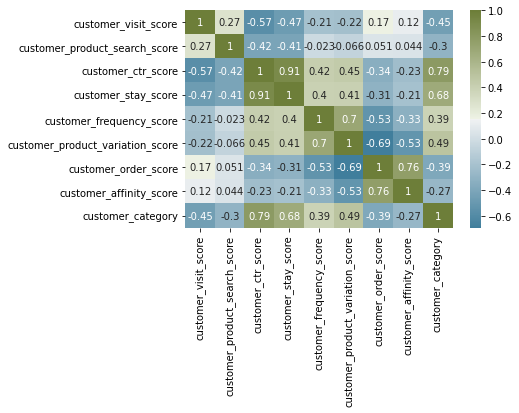

In [772]:
# calculate correlation matrix
corr = train.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(230, 100, as_cmap=True))

In [773]:
#Performing Target based encoding for Coulmns X1 and customer_active_segment
from sklearn import base
from sklearn.model_selection import KFold
class KFoldTargetEncoderTrain(base.BaseEstimator,base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    def fit(self, X, y=None):
        return self
    def transform(self,X):
   #     assert(type(self.targetName) == str)
    #    assert(type(self.colnames) == str)
    #    assert(self.colnames in X.columns)
     #   assert(self.targetName in X.columns)
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = True, random_state=2019)
        print(kf)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            #train set and validation set
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            #test set you take the average of the target values of all samples that have a given category in the entire train set.
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName,                    
                   np.corrcoef(X[self.targetName].values,
                               encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X


In [774]:
targetc = KFoldTargetEncoderTrain('X1','customer_category',n_fold=5)
new_train = targetc.fit_transform(train)



KFold(n_splits=5, random_state=2019, shuffle=True)
Correlation between the new feature, X1_Kfold_Target_Enc and, customer_category is 0.2800996137756755.


In [775]:
targetc = KFoldTargetEncoderTrain('customer_active_segment','customer_category',n_fold=5)
new_train = targetc.fit_transform(train)

KFold(n_splits=5, random_state=2019, shuffle=True)
Correlation between the new feature, customer_active_segment_Kfold_Target_Enc and, customer_category is 0.43072625807702253.


In [776]:
new_train.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category,X1_Kfold_Target_Enc,customer_active_segment_Kfold_Target_Enc
0,csid_1,13.168425,9.447662,-0.070203,-0.139541,0.436956,4.705761,2.537985,7.959503,C,F,0,0.259321,0.126206
1,csid_2,17.092979,7.329056,0.153298,-0.102726,0.380340,4.205138,4.193444,17.517381,C,A,0,0.015008,0.129179
2,csid_3,17.505334,5.143676,0.106709,0.262834,0.417648,4.479070,3.878971,12.595155,C,BA,0,0.150959,0.129179
3,csid_4,31.423381,4.917740,-0.020226,-0.100526,0.778130,5.055535,2.708940,4.795073,AA,F,0,0.255284,0.006173
4,csid_5,11.909502,4.237073,0.187178,0.172891,0.162067,3.445247,3.677360,56.636326,C,AA,0,0.011006,0.129179


In [777]:
new_train['X1']=new_train['X1_Kfold_Target_Enc']
new_train['customer_active_segment']=new_train['customer_active_segment_Kfold_Target_Enc']

In [778]:
new_train.drop(['X1_Kfold_Target_Enc','customer_active_segment_Kfold_Target_Enc','customer_id'],axis=1,inplace=True)

In [779]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10738 entries, 0 to 10737
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_visit_score              10738 non-null  float64
 1   customer_product_search_score     10696 non-null  float64
 2   customer_ctr_score                10738 non-null  float64
 3   customer_stay_score               10701 non-null  float64
 4   customer_frequency_score          10738 non-null  float64
 5   customer_product_variation_score  10692 non-null  float64
 6   customer_order_score              10672 non-null  float64
 7   customer_affinity_score           10738 non-null  float64
 8   customer_active_segment           10738 non-null  float64
 9   X1                                10738 non-null  float64
 10  customer_category                 10738 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 922.9 KB


In [780]:
new_train.describe()

,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
count,10738.000000,10696.000000,10738.000000,10701.000000,10738.000000,10692.000000,10672.000000,10738.000000,10738.000000,10738.000000,10738.000000
mean,19.060941,5.274847,0.175912,0.374230,2.376895,5.788180,3.150071,17.061836,0.120646,0.120597,0.120600
std,7.419609,1.882559,0.372829,1.222031,5.601911,2.531309,1.035416,18.762693,0.140529,0.091593,0.325677
min,0.568965,-0.161940,-0.547989,-0.462494,0.028575,2.752836,0.363338,-0.486834,0.000000,0.011006,0.000000
25%,13.518021,3.971587,0.010840,-0.027666,0.313610,4.193234,2.454017,4.530085,0.063595,0.014803,0.000000
50%,18.774109,5.218479,0.074078,0.037201,0.516830,4.842575,3.118394,12.653357,0.123717,0.143493,0.000000
75%,24.501719,6.520364,0.159606,0.179029,1.125380,6.286400,3.756566,23.114577,0.126206,0.150959,0.000000
max,47.306691,16.638243,2.679474,14.701914,52.395014,18.743836,9.090206,248.552755,0.721461,0.262864,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59b6ac4828>,
      dtype=object)

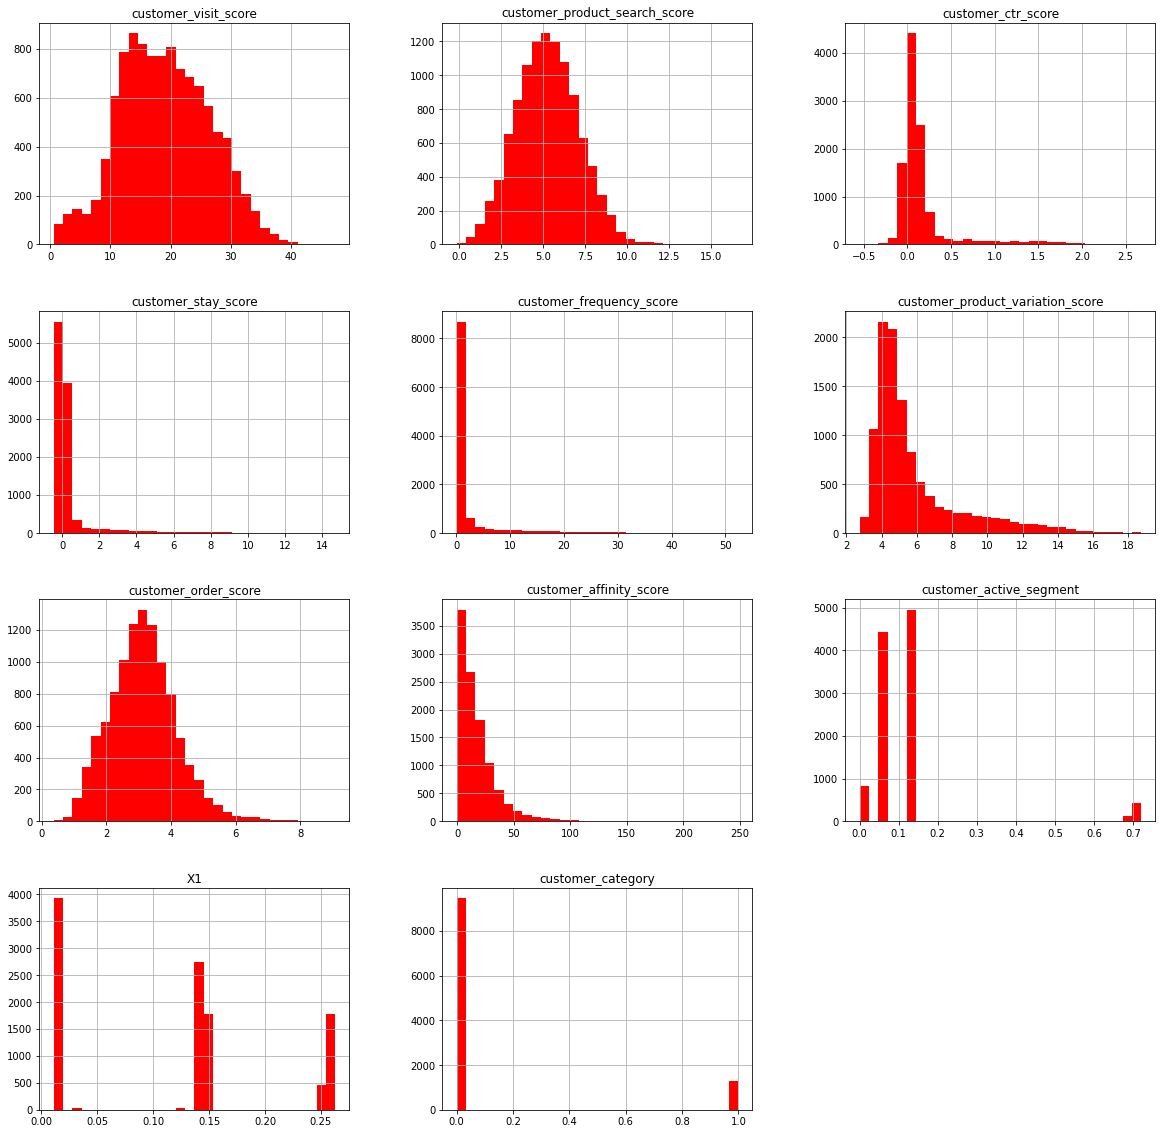

In [781]:
#This gives general idea if there are outliers
new_train.hist(bins=30,figsize=(20,20), color='r')

In [782]:
#Removing outliers using inter-quartile range
cols = ['customer_visit_score','customer_product_search_score','customer_ctr_score','customer_stay_score','customer_frequency_score','customer_product_variation_score','customer_order_score','customer_affinity_score'] # one or more

Q1 = new_train[cols].quantile(0.25)
Q3 = new_train[cols].quantile(0.75)
IQR = Q3 - Q1

train = new_train[~((train[cols] < (Q1 - 1.5 * IQR)) |(new_train[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [783]:
train.describe()

,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
count,7874.000000,7839.000000,7874.000000,7845.000000,7874.000000,7837.000000,7821.000000,7874.000000,7874.000000,7874.000000,7874.000000
mean,20.301394,5.456480,0.065764,0.051862,0.570897,4.866213,3.325380,17.122685,0.097795,0.108675,0.017653
std,6.551667,1.652104,0.085738,0.124856,0.396499,1.035776,0.724480,11.005005,0.083992,0.088256,0.131695
min,6.959290,0.729173,-0.206223,-0.236595,0.061014,2.961378,1.599714,0.505918,0.000000,0.011006,0.000000
25%,14.886533,4.273116,0.006002,-0.032870,0.306064,4.146447,2.805574,8.495286,0.062994,0.014803,0.000000
50%,19.959487,5.375487,0.060567,0.021469,0.457062,4.655135,3.268828,14.804098,0.065662,0.143255,0.000000
75%,25.206123,6.589078,0.120492,0.105190,0.692231,5.350941,3.786002,23.564231,0.126206,0.147059,0.000000
max,40.671151,10.338975,0.378051,0.488577,2.341533,9.414549,5.694993,50.986320,0.721461,0.262864,1.000000


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


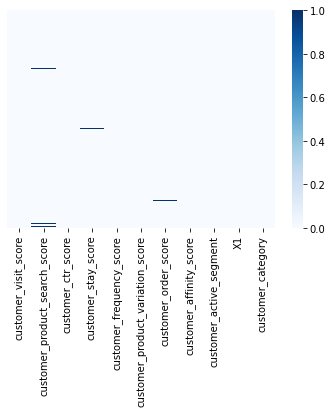

In [784]:
#Visualizing null values
sns.heatmap(train.isnull(), cmap='Blues',yticklabels=False,cbar='False')
train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [785]:
#Replacing null values with mean values
train['customer_product_search_score'].fillna(train['customer_product_search_score'].mean(), inplace = True)
train['customer_ctr_score'].fillna(train['customer_ctr_score'].mean(), inplace = True)
train['customer_order_score'].fillna(train['customer_order_score'].mean(), inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


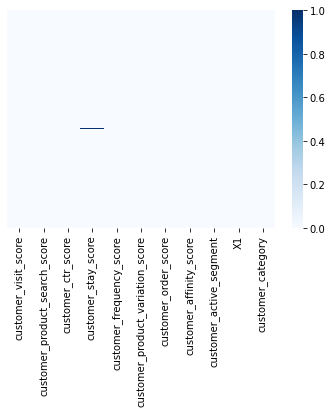

In [786]:
sns.heatmap(train.isnull(), cmap='Blues',yticklabels=False,cbar='False')

In [787]:
train['customer_stay_score'].fillna(train['customer_stay_score'].mean(), inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


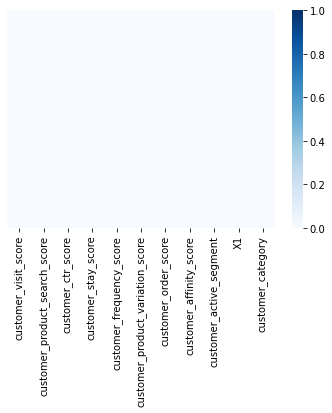

In [788]:
sns.heatmap(train.isnull(), cmap='Blues',yticklabels=False,cbar='False')

In [789]:
#train=train.reindex(columns=['customer_visit_score','customer_product_search_score',	'customer_ctr_score',	'customer_stay_score',	'customer_frequency_score',	'customer_product_variation_score',	'customer_order_score',	'customer_affinity_score','X1',	'customer_active_segment','customer_category'])

In [790]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7874 entries, 0 to 10737
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_visit_score              7874 non-null   float64
 1   customer_product_search_score     7874 non-null   float64
 2   customer_ctr_score                7874 non-null   float64
 3   customer_stay_score               7874 non-null   float64
 4   customer_frequency_score          7874 non-null   float64
 5   customer_product_variation_score  7837 non-null   float64
 6   customer_order_score              7874 non-null   float64
 7   customer_affinity_score           7874 non-null   float64
 8   customer_active_segment           7874 non-null   float64
 9   X1                                7874 non-null   float64
 10  customer_category                 7874 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 738.2 KB


In [791]:
#cols=['customer_visit_score','customer_product_search_score',	'customer_ctr_score',	'customer_stay_score',	'customer_frequency_score',	'customer_product_variation_score',	'customer_order_score',	'customer_affinity_score','X1',	'customer_active_segment','customer_category']
#for i in cols:
  #train[i].round(3)

In [792]:
train.head()

,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,13.168425,9.447662,-0.070203,-0.139541,0.436956,4.705761,2.537985,7.959503,0.126206,0.259321,0
1,17.092979,7.329056,0.153298,-0.102726,0.380340,4.205138,4.193444,17.517381,0.129179,0.015008,0
2,17.505334,5.143676,0.106709,0.262834,0.417648,4.479070,3.878971,12.595155,0.129179,0.150959,0
3,31.423381,4.917740,-0.020226,-0.100526,0.778130,5.055535,2.708940,4.795073,0.006173,0.255284,0
5,9.007922,7.051568,0.161564,0.040997,0.191935,4.209840,3.181961,18.862680,0.129179,0.150959,0


In [793]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7874 entries, 0 to 10737
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_visit_score              7874 non-null   float64
 1   customer_product_search_score     7874 non-null   float64
 2   customer_ctr_score                7874 non-null   float64
 3   customer_stay_score               7874 non-null   float64
 4   customer_frequency_score          7874 non-null   float64
 5   customer_product_variation_score  7837 non-null   float64
 6   customer_order_score              7874 non-null   float64
 7   customer_affinity_score           7874 non-null   float64
 8   customer_active_segment           7874 non-null   float64
 9   X1                                7874 non-null   float64
 10  customer_category                 7874 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 738.2 KB


In [794]:
#This will help to encode out data in test file
train['X1'].value_counts()

0.147059    693
0.144485    680
0.143255    677
0.143493    666
0.150959    649
0.015008    452
0.012707    439
0.013774    432
0.014803    424
0.014254    422
0.259426    263
0.262864    256
0.255284    242
0.253933    237
0.259321    227
0.011006    224
0.013057    219
0.012346    218
0.015456    216
0.016406    211
0.120600     27
Name: X1, dtype: int64

In [795]:
train['customer_active_segment'].value_counts()

0.123717    752
0.129451    747
0.129179    718
0.065662    717
0.126206    715
0.062994    713
0.125694    709
0.063595    698
0.065463    674
0.062849    660
0.006173    129
0.000000     74
0.006135     73
0.006079     69
0.003030     67
0.006061     64
0.002959     58
0.005650     53
0.005865     53
0.717703     29
0.710706     23
0.714286     22
0.721461     21
0.689573     19
0.120600     17
Name: customer_active_segment, dtype: int64

In [796]:
train =train[~train.isin([np.nan, np.inf, -np.inf]).any(1)]
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values
y.shape


(7837,)

In [797]:
X.shape

(7837, 10)

In [798]:
#performing Feature Scaling
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)

In [799]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [800]:
#from sklearn.linear_model import LogisticRegression
#from sklearn import svm
#from sklearn.naive_bayes import GaussianNB
#modelsvm=svm.SVC(probability=True)
#modellr = LogisticRegression(random_state = 0,max_iter=1000000)
#modellr.fit(X_train, y_train)
#modelsvm.fit(X_train, y_train)
#modelnb=GaussianNB()
#modelnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [801]:
#training the model using decision tree classifier
modeldt=tree.DecisionTreeClassifier()
modeldt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [802]:
from sklearn.model_selection import GridSearchCV
param_dict={"criterion":['gini','entropy'],"max_depth":range(1,10),"min_samples_split":range(1,10),"min_samples_leaf":range(1,5)}

In [803]:
#Tuning hyperparameter using GridSearch Cv technique
grid=GridSearchCV(modeldt,param_grid=param_dict,cv=10,verbose=1,n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2790 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 5806 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  2.4min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                    

In [804]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

In [805]:
modeldt=tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=1,min_samples_split=5,criterion='entropy')
modeldt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [806]:
y_pred=modeldt.predict(X_test)

In [807]:
#y=np.array(y_test)

In [808]:

precision_metric = sklearn.metrics.precision_score(y_test, y_pred, average = "macro")
print(precision_metric)


0.9918242207460399


In [843]:
test=pd.read_csv('test.csv')

In [844]:
#preparing test data
import random
def label(element):
  if element=='BA':
    return 0.150959  
  elif element=='A':
      return 0.014109
  elif element=='F':
    return .258165
  elif element=='AA':
    return 0.0136542
  elif element=='E':
    return 0.120600
test['X1']=test['X1'].map(label)

In [845]:
import random
def label(element):
  if element=='C':
    return 0.127449
  elif element=='B':
      return 0.079518
  elif element=='D':
    return 0.005244
  elif element=='AA':
    return 0.005244
  elif element=='A':
    return 0.612388
test['customer_active_segment']=test['customer_active_segment'].map(label)

In [846]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       7160 non-null   object 
 1   customer_visit_score              7160 non-null   float64
 2   customer_product_search_score     7131 non-null   float64
 3   customer_ctr_score                7160 non-null   float64
 4   customer_stay_score               7144 non-null   float64
 5   customer_frequency_score          7160 non-null   float64
 6   customer_product_variation_score  7117 non-null   float64
 7   customer_order_score              7119 non-null   float64
 8   customer_affinity_score           7160 non-null   float64
 9   customer_active_segment           7148 non-null   float64
 10  X1                                7135 non-null   float64
dtypes: float64(10), object(1)
memory usage: 615.4+ KB


In [847]:
test['customer_stay_score'].fillna(test['customer_stay_score'].mean(), inplace = True)
test['customer_product_search_score'].fillna(test['customer_product_search_score'].mean(), inplace = True)
test['customer_stay_score'].fillna(test['customer_stay_score'].mean(), inplace = True)
test['customer_product_variation_score'].fillna(test['customer_product_variation_score'].mean(), inplace = True)
test['customer_order_score'].fillna(test['customer_order_score'].mean(), inplace = True)
test['customer_active_segment'].fillna(test['customer_active_segment'].mean(), inplace = True)
test['X1'].fillna(test['X1'].mean(), inplace = True)

In [848]:
test['customer_active_segment'].value_counts()

0.127449    3251
0.079518    3127
0.005244     521
0.612388     249
0.114466      12
Name: customer_active_segment, dtype: int64

In [849]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       7160 non-null   object 
 1   customer_visit_score              7160 non-null   float64
 2   customer_product_search_score     7160 non-null   float64
 3   customer_ctr_score                7160 non-null   float64
 4   customer_stay_score               7160 non-null   float64
 5   customer_frequency_score          7160 non-null   float64
 6   customer_product_variation_score  7160 non-null   float64
 7   customer_order_score              7160 non-null   float64
 8   customer_affinity_score           7160 non-null   float64
 9   customer_active_segment           7160 non-null   float64
 10  X1                                7160 non-null   float64
dtypes: float64(10), object(1)
memory usage: 615.4+ KB


In [850]:
x=test.iloc[:,0]
x

0       csid_10739
1       csid_10740
2       csid_10741
3       csid_10742
4       csid_10743
           ...    
7155    csid_17894
7156    csid_17895
7157    csid_17896
7158    csid_17897
7159    csid_17898
Name: customer_id, Length: 7160, dtype: object

In [851]:
test.drop(['customer_id'],axis=1,inplace=True)

In [853]:
y_test_pred=modeldt.predict(test)
y_test=pd.DataFrame([y_test_pred]).T
y_test

,0
0,0
1,0
2,0
3,0
4,0
...,...
7155,0
7156,0
7157,0
7158,0


In [854]:
x


0       csid_10739
1       csid_10740
2       csid_10741
3       csid_10742
4       csid_10743
           ...    
7155    csid_17894
7156    csid_17895
7157    csid_17896
7158    csid_17897
7159    csid_17898
Name: customer_id, Length: 7160, dtype: object

In [855]:
my_submission=pd.DataFrame([x,y_test_pred])

In [856]:
my_submission=my_submission.T
my_submission.columns=['customer_id','customer_category']
my_submission.to_csv('submission.csv',index=False)

In [857]:
my_submission['customer_category'].value_counts()

0    7159
1       1
Name: customer_category, dtype: int64